In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro
import scikit_posthocs as sp
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal

In [2]:
df = pd.read_csv('/home/amjad-alhadeed/Downloads/project_2_data.csv')

## Data Collection

In [3]:
# Preview data
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Cleaning

In [5]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [6]:
# Check missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage[missing_percentage > 0].sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

In [7]:
# Drop irrelevant columns
df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [8]:
# Fill missing values and count categories
df['FireplaceQu'] = df['FireplaceQu'].fillna('No Fireplace')
df['FireplaceQu'].value_counts()

FireplaceQu
No Fireplace    690
Gd              380
TA              313
Fa               33
Ex               24
Po               20
Name: count, dtype: int64

In [9]:
# Fill missing 'LotFrontage' based on neighborhood median
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

df['LotFrontage'].isnull().sum()

np.int64(0)

In [10]:
# Fill missing values for garage columns
garage_columns = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for col in garage_columns:
    df[col] = df[col].fillna('No Garage')

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

df[garage_columns + ['GarageYrBlt']].isnull().sum()

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageYrBlt     0
dtype: int64

In [11]:
# Fill missing values for basement columns
basement_columns = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond']

for col in basement_columns:
    df[col] = df[col].fillna('No Basement')

df[basement_columns].isnull().sum()

BsmtFinType1    0
BsmtFinType2    0
BsmtExposure    0
BsmtQual        0
BsmtCond        0
dtype: int64

In [12]:
# Fill missing values for 'MasVnrType', 'MasVnrArea', and 'Electrical', then check remaining nulls
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

df[['MasVnrType', 'MasVnrArea', 'Electrical']].isnull().sum()

MasVnrType    0
MasVnrArea    0
Electrical    0
dtype: int64

In [13]:
# Check for remaining missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

## Data Visualization and Exploration

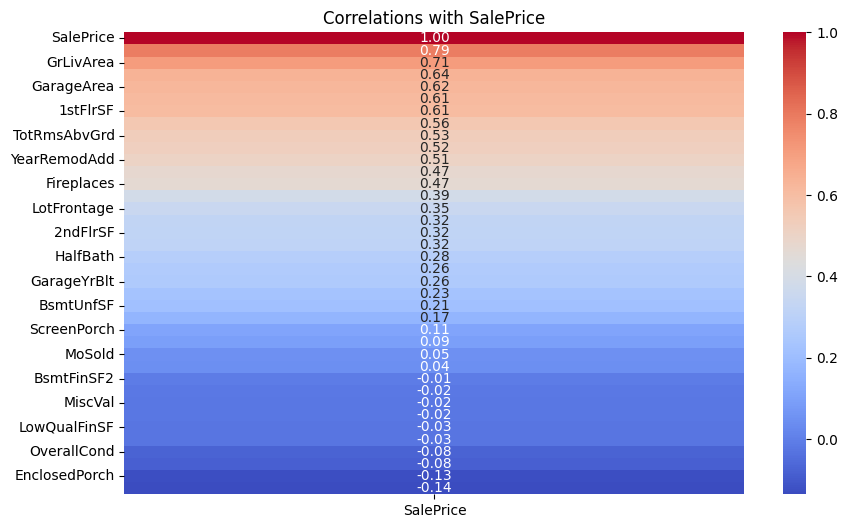

In [14]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlations with SalePrice')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/1.png', dpi=300, bbox_inches='tight')


plt.show()

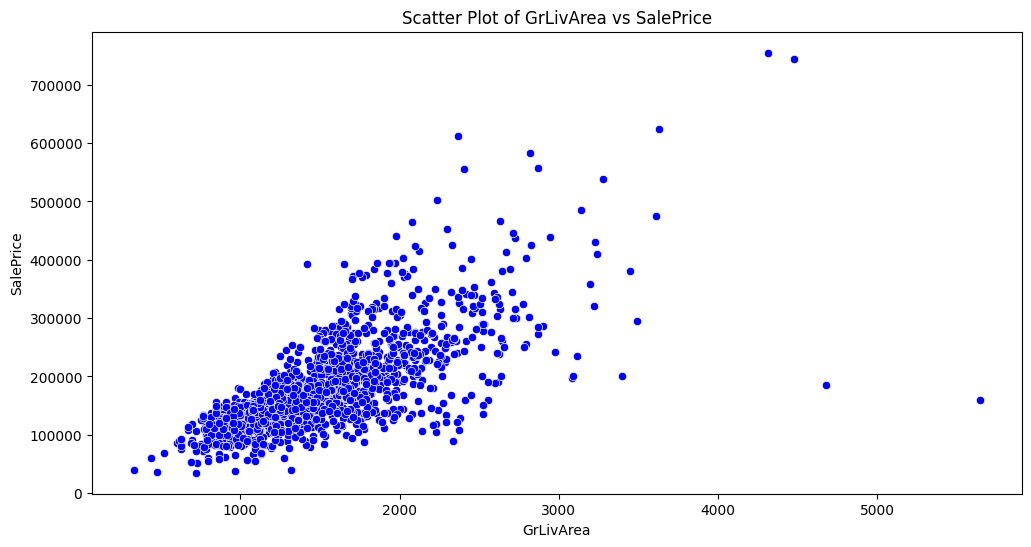

In [38]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], color='blue')
plt.title('Scatter Plot of GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/2.png', dpi=300, bbox_inches='tight')


plt.show()

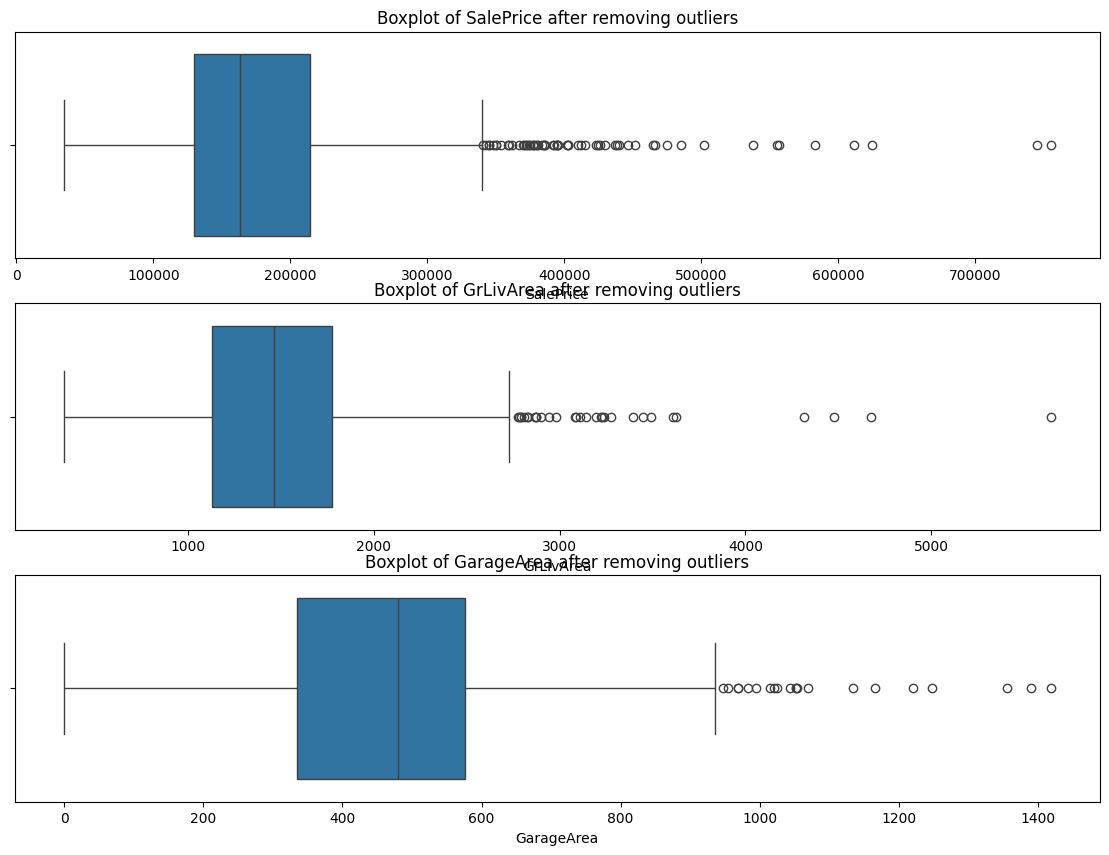

In [39]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)  
sns.boxplot(x=df['SalePrice'])
plt.title('Boxplot of SalePrice after removing outliers')


plt.subplot(3, 1, 2)  
sns.boxplot(x=df['GrLivArea'])
plt.title('Boxplot of GrLivArea after removing outliers')

plt.subplot(3, 1, 3)
sns.boxplot(x=df['GarageArea'])
plt.title('Boxplot of GarageArea after removing outliers')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/3.png', dpi=300, bbox_inches='tight')


plt.show()

In [17]:
# Remove outliers from specified features using IQR method
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

df_cleaned = remove_outliers(df, 'SalePrice')
df_cleaned = remove_outliers(df_cleaned, 'GrLivArea')
df_cleaned = remove_outliers(df_cleaned, 'GarageArea')

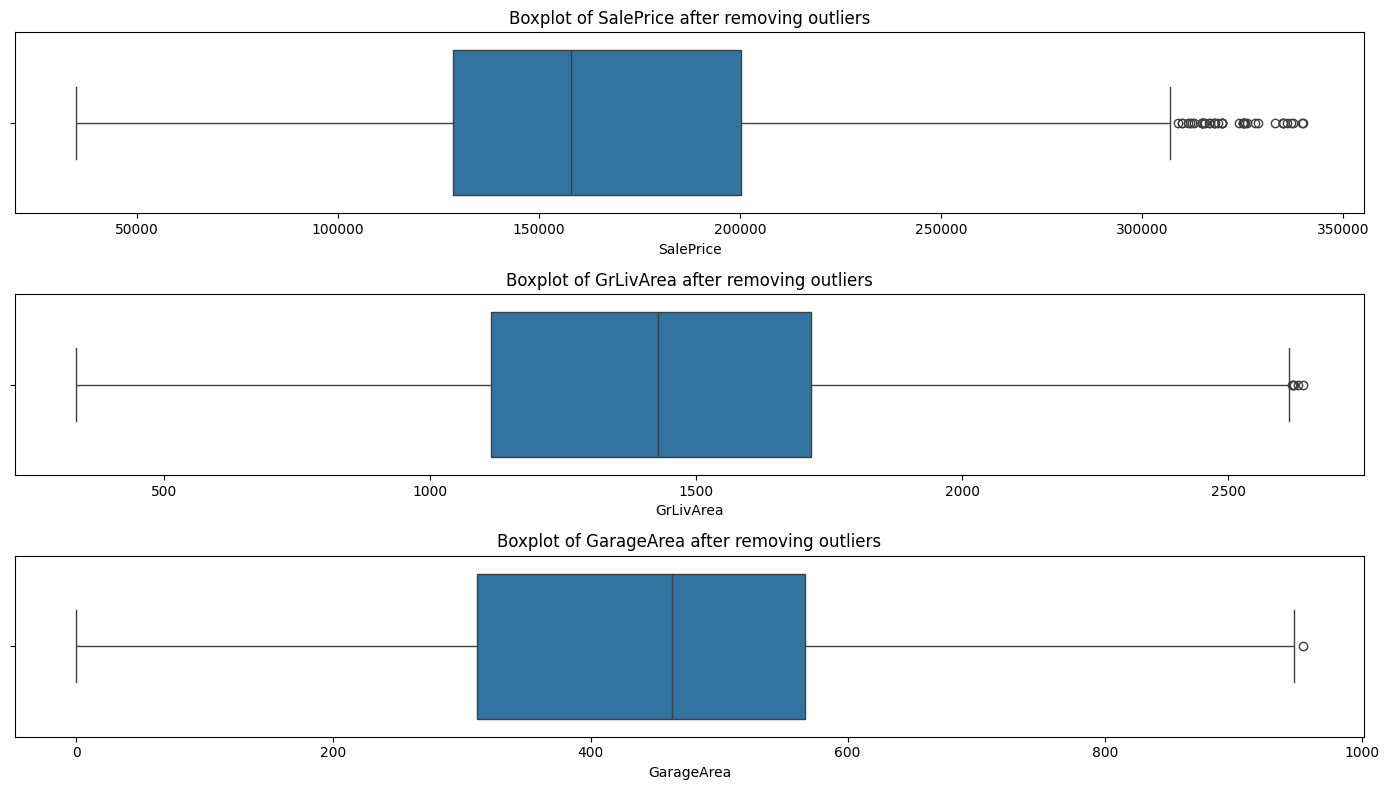

In [18]:
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
sns.boxplot(x=df_cleaned['SalePrice'])
plt.title('Boxplot of SalePrice after removing outliers')

plt.subplot(3, 1, 2)
sns.boxplot(x=df_cleaned['GrLivArea'])
plt.title('Boxplot of GrLivArea after removing outliers')

plt.subplot(3, 1, 3) 
sns.boxplot(x=df_cleaned['GarageArea'])
plt.title('Boxplot of GarageArea after removing outliers')

plt.tight_layout()

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/4.png', dpi=300, bbox_inches='tight')


plt.show()

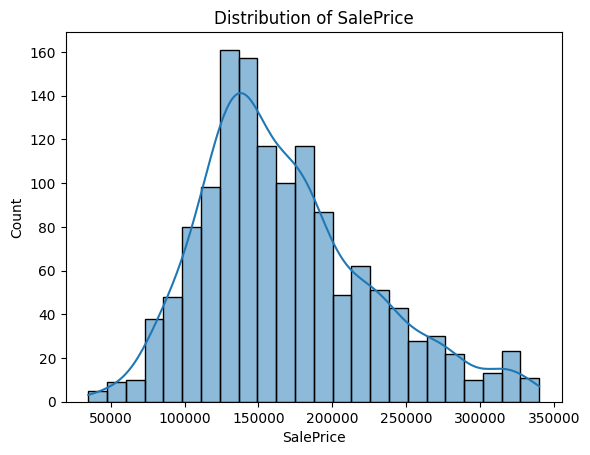

In [19]:
sns.histplot(df_cleaned['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/5.png', dpi=300, bbox_inches='tight')


plt.show()

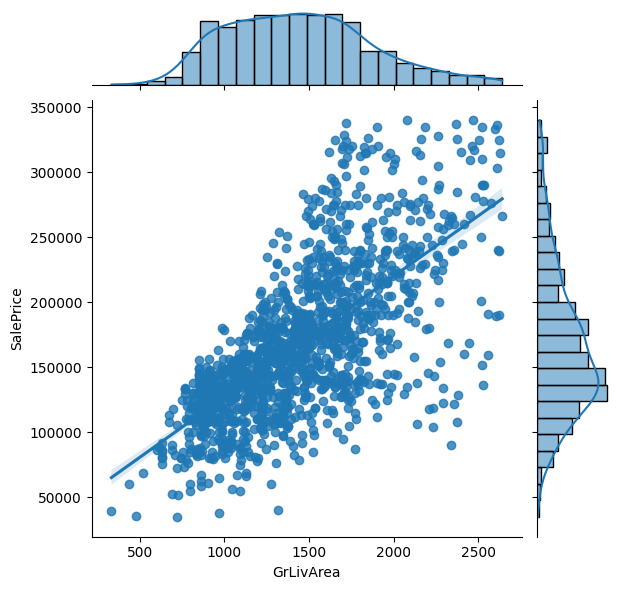

In [43]:
sns.jointplot(x='GrLivArea', y='SalePrice', data=df_cleaned, kind='reg')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/6.png', dpi=300, bbox_inches='tight')

plt.show()

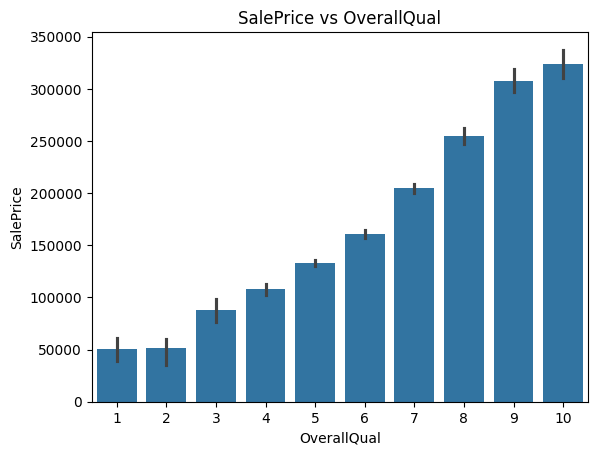

In [21]:
sns.barplot(x='OverallQual', y='SalePrice', data=df_cleaned)
plt.title('SalePrice vs OverallQual')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/7.png', dpi=300, bbox_inches='tight')

plt.show()

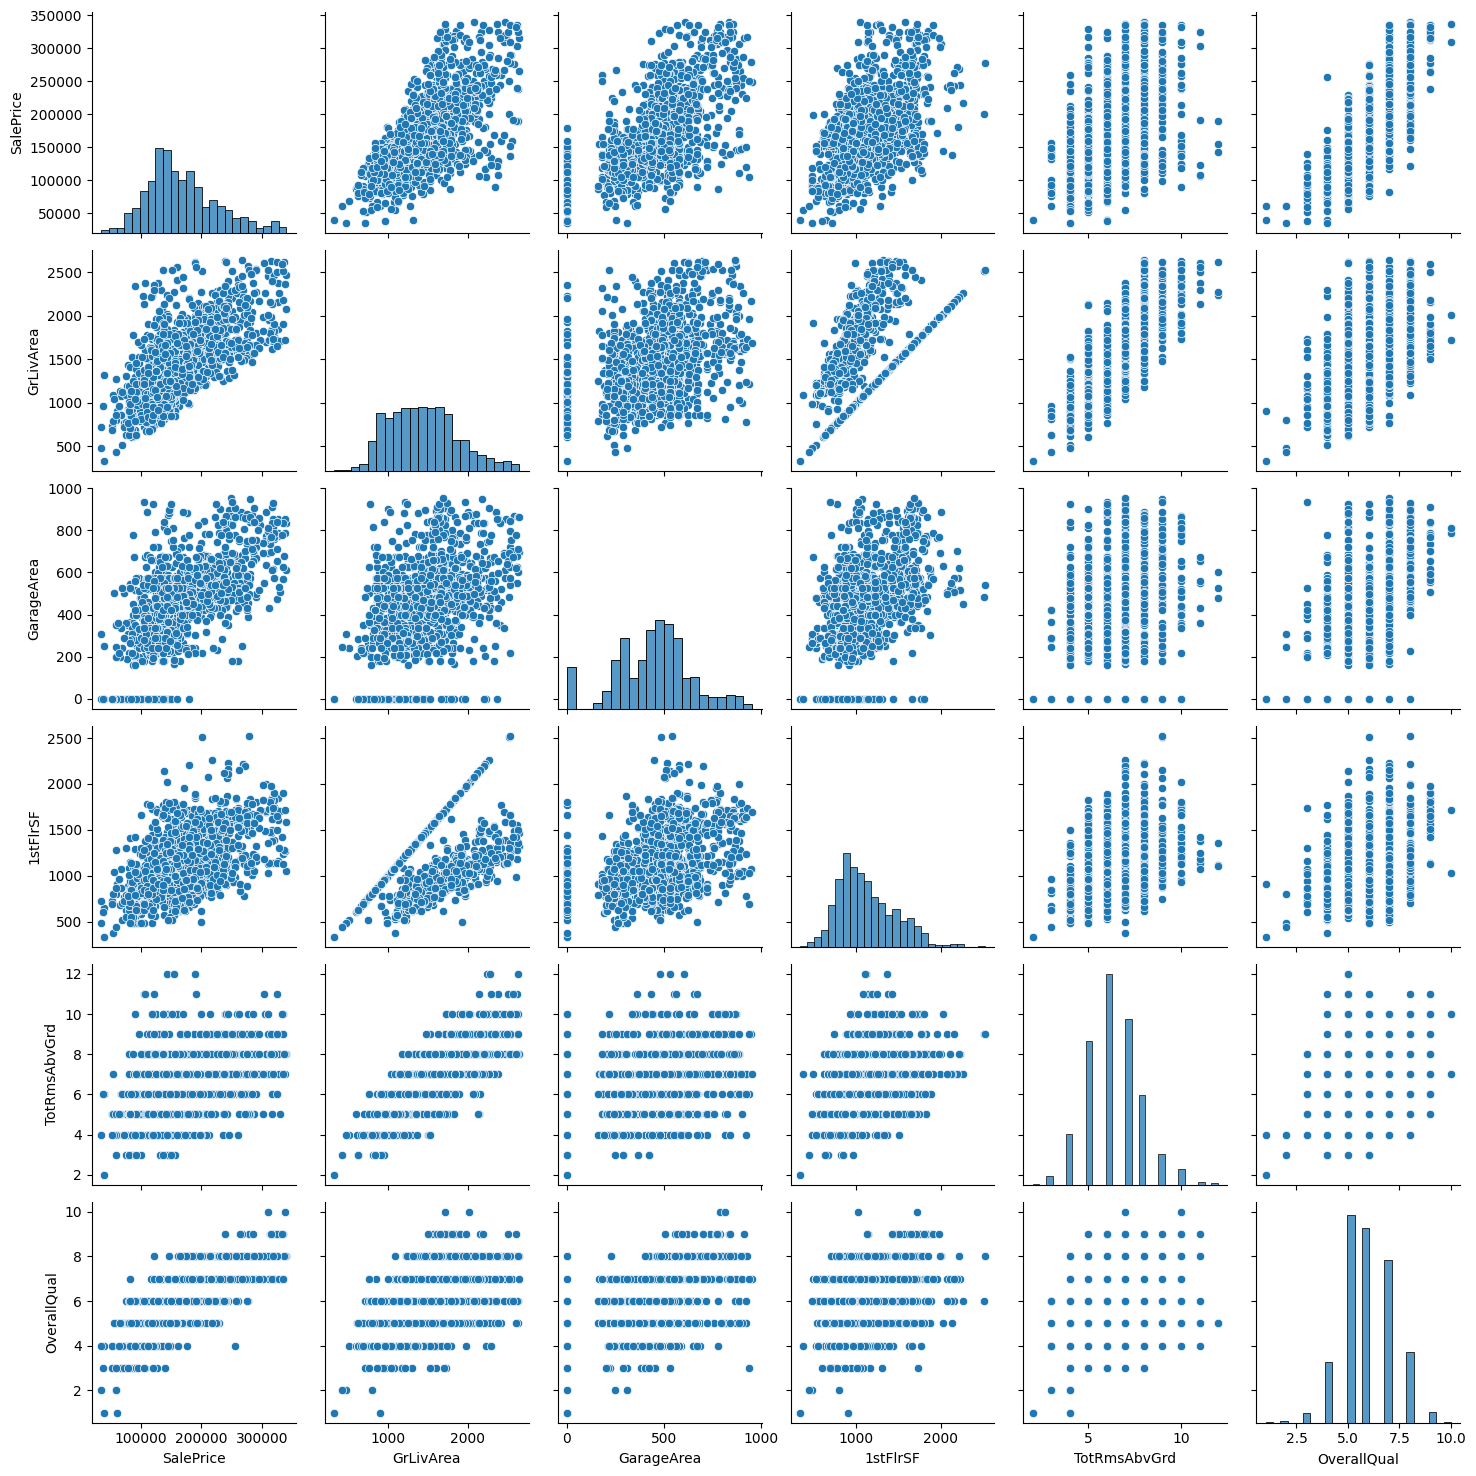

In [22]:
sns.pairplot(df_cleaned[['SalePrice', 'GrLivArea', 'GarageArea', '1stFlrSF', 'TotRmsAbvGrd', 'OverallQual']])
plt.show()

## Feature Engineering and Data Preprocessing

In [23]:
# Get unique values
df_cleaned['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', 'No Garage'], dtype=object)

In [24]:
# Perform Shapiro-Wilk test for normality on 'SalePrice' by 'GarageFinish' groups
for group in df_cleaned['GarageFinish'].unique():
    stat, p = shapiro(df_cleaned[df_cleaned['GarageFinish'] == group]['SalePrice'])
    print(f"{group}: W-statistic={stat}, P-value={p}")

    if p < 0.05:
        print(f"Reject the null hypothesis: {group} is not normally distributed.")
    else:
        print(f"Fail to reject the null hypothesis: {group} is normally distributed.")

RFn: W-statistic=0.9740892884733928, P-value=1.469458481704628e-06
Reject the null hypothesis: RFn is not normally distributed.
Unf: W-statistic=0.927998977404445, P-value=2.8124252700652436e-16
Reject the null hypothesis: Unf is not normally distributed.
Fin: W-statistic=0.9646931807509438, P-value=1.2656302131876746e-06
Reject the null hypothesis: Fin is not normally distributed.
No Garage: W-statistic=0.988971187735256, P-value=0.736338145612036
Fail to reject the null hypothesis: No Garage is normally distributed.


In [25]:
# Perform Kruskal-Wallis test to check for differences in 'SalePrice' across 'GarageFinish' groups
stat, p_value = kruskal(
    df_cleaned[df_cleaned['GarageFinish'] == 'Fin']['SalePrice'],
    df_cleaned[df_cleaned['GarageFinish'] == 'RFn']['SalePrice'],
    df_cleaned[df_cleaned['GarageFinish'] == 'Unf']['SalePrice'],
    df_cleaned[df_cleaned['GarageFinish'] == 'No Garage']['SalePrice']
)

print(f"Kruskal-Wallis statistic: {stat}")
print(f"P-value: {p_value}")


if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference exists among the groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference among the groups.")

Kruskal-Wallis statistic: 572.4263800830435
P-value: 9.566377417287636e-124
Reject the null hypothesis: Significant difference exists among the groups.


In [26]:
# Perform Dunn's post-hoc test with Bonferroni correction for 'SalePrice' across 'GarageFinish' groups
dunn_test = sp.posthoc_dunn(df_cleaned, val_col='SalePrice', group_col='GarageFinish', p_adjust='bonferroni')

print(dunn_test)

                    Fin     No Garage           RFn           Unf
Fin        1.000000e+00  9.305946e-55  5.597204e-02  3.851905e-71
No Garage  9.305946e-55  1.000000e+00  4.841722e-47  1.651400e-08
RFn        5.597204e-02  4.841722e-47  1.000000e+00  1.967620e-61
Unf        3.851905e-71  1.651400e-08  1.967620e-61  1.000000e+00


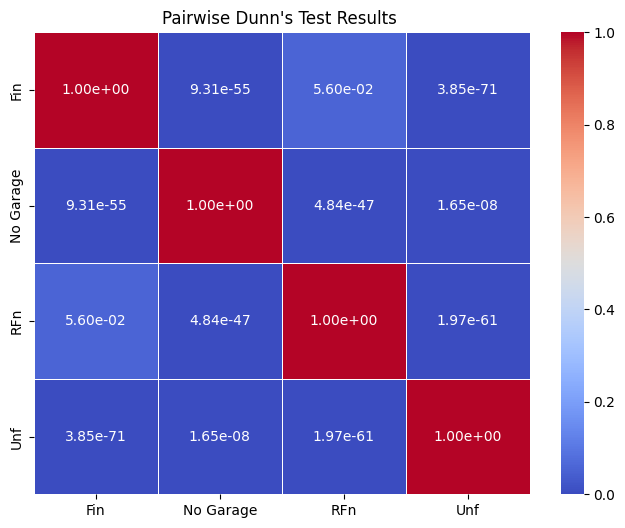

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(dunn_test, annot=True, cmap="coolwarm", fmt=".2e", linewidths=0.5)
plt.title("Pairwise Dunn's Test Results ")

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/8.png', dpi=300, bbox_inches='tight')

plt.show()

In [28]:
# Convert all columns in df_cleaned to numeric
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

In [29]:
# Drop unnecessary columns
columns_to_drop = ['Id']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

## Splitting the Dataset

In [30]:
# Prepare data by splitting, selecting numeric columns, and identifying columns for imputation
X = df_cleaned.drop(columns=['SalePrice'])  
y = df_cleaned['SalePrice']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

all_missing_cols = X_train[numeric_columns].columns[X_train[numeric_columns].isnull().all()]

numeric_columns_to_impute = [col for col in numeric_columns if col not in all_missing_cols]

In [31]:
# Impute missing values and handle columns with all missing values for training and test sets
numeric_imputer = SimpleImputer(strategy='mean')

X_train_imputed = numeric_imputer.fit_transform(X_train[numeric_columns_to_impute])
X_test_imputed = numeric_imputer.transform(X_test[numeric_columns_to_impute])

X_train_imputed_df = pd.DataFrame(X_train_imputed, index=X_train.index, columns=numeric_columns_to_impute)
X_test_imputed_df = pd.DataFrame(X_test_imputed, index=X_test.index, columns=numeric_columns_to_impute)

X_train[numeric_columns_to_impute] = X_train_imputed_df
X_test[numeric_columns_to_impute] = X_test_imputed_df

X_train = X_train.drop(columns=all_missing_cols)
X_test = X_test.drop(columns=all_missing_cols)

constant_imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train = pd.DataFrame(constant_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(constant_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [32]:
# Scale the training and test sets using StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [33]:
# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]

print(vif_data)

          Feature       VIF
0      MSSubClass  1.738081
1     LotFrontage  1.544409
2         LotArea  1.238563
3     OverallQual  2.914103
4     OverallCond  1.571030
5       YearBuilt  4.060298
6    YearRemodAdd  2.206943
7      MasVnrArea  1.221164
8      BsmtFinSF1       inf
9      BsmtFinSF2       inf
10      BsmtUnfSF       inf
11    TotalBsmtSF       inf
12       1stFlrSF       inf
13       2ndFlrSF       inf
14   LowQualFinSF       inf
15      GrLivArea       inf
16   BsmtFullBath  2.290060
17   BsmtHalfBath  1.182439
18       FullBath  2.890560
19       HalfBath  2.228010
20   BedroomAbvGr  2.320499
21   KitchenAbvGr  1.665946
22   TotRmsAbvGrd  4.445158
23     Fireplaces  1.513799
24    GarageYrBlt  1.942222
25     GarageCars  6.196805
26     GarageArea  5.354116
27     WoodDeckSF  1.218492
28    OpenPorchSF  1.189566
29  EnclosedPorch  1.259142
30      3SsnPorch  1.032531
31    ScreenPorch  1.104748
32       PoolArea  1.038289
33        MiscVal  1.030984
34         MoSold  1

/home/amjad-alhadeed/myenv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [34]:
# Drop high VIF columns from the scaled training and test sets
high_vif_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']

X_train_vif_reduced = X_train_scaled.drop(columns=high_vif_columns)
X_test_vif_reduced = X_test_scaled.drop(columns=high_vif_columns)

## Model Selection

In [46]:
# Train and evaluate a linear regression model
linear_model_vif_reduced = LinearRegression()
linear_model_vif_reduced.fit(X_train_vif_reduced, y_train)

y_pred_vif_reduced = linear_model_vif_reduced.predict(X_test_vif_reduced)

mse_vif_reduced = mean_squared_error(y_test, y_pred_vif_reduced)
r2_vif_reduced = r2_score(y_test, y_pred_vif_reduced)

print(f"Multiple Linear Regression (VIF Reduced) - Mean Squared Error: {mse_vif_reduced}")
print(f"Multiple Linear Regression (VIF Reduced) - R-squared: {r2_vif_reduced}")

Multiple Linear Regression (VIF Reduced) - Mean Squared Error: 567631130.6869127
Multiple Linear Regression (VIF Reduced) - R-squared: 0.8348388422613899


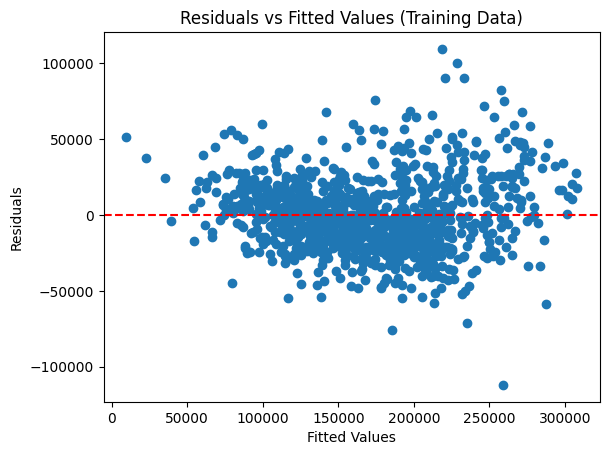

In [36]:
y_train_pred = linear_model_vif_reduced.predict(X_train_vif_reduced)

residuals_train = y_train - y_train_pred

plt.scatter(y_train_pred, residuals_train)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Training Data)')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/9.png', dpi=300, bbox_inches='tight')

plt.show()

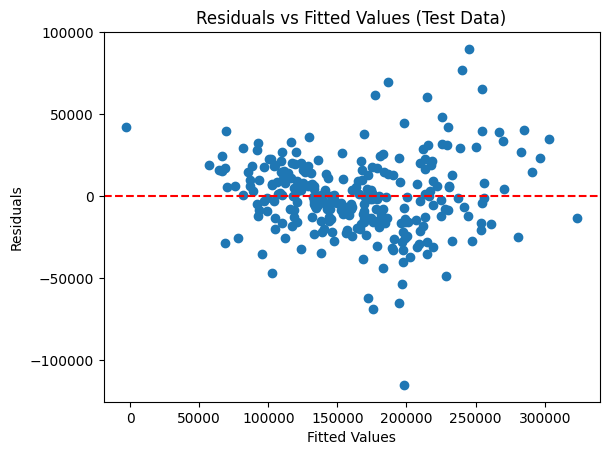

In [37]:
y_test_pred = linear_model_vif_reduced.predict(X_test_vif_reduced)

residuals_test = y_test - y_test_pred

plt.scatter(y_test_pred, residuals_test)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Test Data)')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/10.png', dpi=300, bbox_inches='tight')


plt.show()

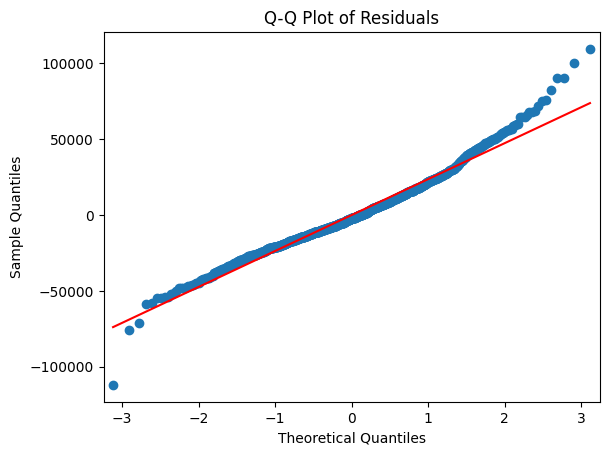

In [49]:
y_train_pred = linear_model_vif_reduced.predict(X_train_vif_reduced)

residuals = y_train - y_train_pred

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')

plt.savefig('/home/amjad-alhadeed/Desktop/House Price/11.png', dpi=300, bbox_inches='tight')


plt.show()